In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases   #参见资料包，或者在文章底部copy
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward #参见资料包
import lr_utils #参见资料包，或者在文章底部copy

C:\Users\Shangjian\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#如何建立深度网络初始化参数
def initialize_parameter_deep(lays_dim):
    np.random.seed(3)
    parameters = {}
    L = len(lays_dim)
    for l in range(1,L):
        #parameters["W" + str(l)] = np.random.randn(lays_dim[l],lays_dim[l-1])*0.01
        parameters["W" + str(l)] = np.random.randn(lays_dim[l], lays_dim[l - 1]) / np.sqrt(lays_dim[l - 1])
        parameters["b" + str(l)] = np.zeros((lays_dim[l],1))
        
    #断言判断参数维度是否正确
    for l in range(1,L):
        assert(parameters["W" + str(l)].shape == (lays_dim[l],lays_dim[l-1]))
        assert(parameters["b" + str(l)].shape == (lays_dim[l],1))
    
    return parameters

In [3]:
#第二步，建立向前传播模型
def nn_forward_model(X,parameters):
    A = X
    caches_A = []
    caches_Z = []
    L = len(parameters) //2
    caches_A.append(A)
    for l in range(1,L):
        A_pre = A
        Z = np.dot(parameters["W" + str(l)],A_pre) + parameters["b" + str(l)]
        A,cache = relu(Z)
        caches_A.append(A)
        caches_Z.append(cache)
    ZL = np.dot(parameters["W" + str(L)],A) + parameters["b" + str(L)]
    AL,cache = sigmoid(ZL)
    caches_A.append(AL)
    caches_Z.append(cache)
    caches = (caches_A,caches_Z)
    return AL,caches

In [4]:
def compute_cost(AL,Y):
    """
    实施等式（4）定义的成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m

    cost = np.squeeze(cost)
    assert(cost.shape == ())

    return cost

In [5]:
#后向传播模型
def nn_back_model(AL,Y,parameters,caches):
    dZ = AL - Y
    L = len(parameters) // 2 +1
    m = AL.shape[1]
    back_parameters = {}
    caches_A,caches_Z = caches
    for l in reversed(range(1,L)):
        dW = np.dot(dZ,caches_A[l-1].T)/m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA = np.dot(parameters["W" + str(l)].T,dZ)
        if l-2 >=0:
            dZ = relu_backward(dA,caches_Z[l-2])        
        back_parameters["W" + str(l)] = dW
        back_parameters["b" + str(l)] = db
        assert(dW.shape == (caches_A[l].shape[0],caches_A[l-1].shape[0]))
    return back_parameters

In [6]:
#更新参数
def update_parameters(parameters,back_parameters,learning_rate):
    L = len(parameters) // 2 + 1
    for l in range(1,L):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * back_parameters["W" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * back_parameters["b" + str(l)]
    return parameters

In [7]:
def nn_model(X,Y,lays_dim,learning_rate=0.0075,num_iterations=3000,print_cost=False,isPlot=True):
    
    np.random.seed(1)
    
    costs = []
    
    parameters = initialize_parameter_deep(lays_dim)
    
    for i in range(0,num_iterations):
        
        AL,caches = nn_forward_model(X,parameters)
        
        cost = compute_cost(AL,Y)
    
        back_parameters = nn_back_model(AL,Y,parameters,caches)
        
        parameters = update_parameters(parameters,back_parameters,learning_rate)
        
        #保存成本
        if i % 100 == 0:
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print('第,' + str(i) + '次迭代打印成本值' + str(np.squeeze(cost)))
        
            #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters


In [15]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层

    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数

    返回：
     p - 给定数据集X的预测
    """

    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))

    #根据参数前向传播
    probas, caches = nn_forward_model(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("准确度为: "  + str(float(np.sum((p == y))/m)))

    return p

In [12]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y
train_y.shape

(1, 209)

第,0次迭代打印成本值0.715731513413713
第,100次迭代打印成本值0.6747377593469114
第,200次迭代打印成本值0.6603365433622127
第,300次迭代打印成本值0.6462887802148751
第,400次迭代打印成本值0.6298131216927773
第,500次迭代打印成本值0.6060056229265339
第,600次迭代打印成本值0.5690041263975134
第,700次迭代打印成本值0.519796535043806
第,800次迭代打印成本值0.46415716786282285
第,900次迭代打印成本值0.4084203004829892
第,1000次迭代打印成本值0.3731549921606905
第,1100次迭代打印成本值0.30572374573047123
第,1200次迭代打印成本值0.26810152847740853
第,1300次迭代打印成本值0.23872474827672555
第,1400次迭代打印成本值0.20632263257914712
第,1500次迭代打印成本值0.1794388692749351
第,1600次迭代打印成本值0.15798735818800963
第,1700次迭代打印成本值0.1424041301227361
第,1800次迭代打印成本值0.12865165997884204
第,1900次迭代打印成本值0.11244314998150322
第,2000次迭代打印成本值0.08505631034957523
第,2100次迭代打印成本值0.05758391198599437
第,2200次迭代打印成本值0.04456753454690802
第,2300次迭代打印成本值0.038082751665961624
第,2400次迭代打印成本值0.03441074901839329


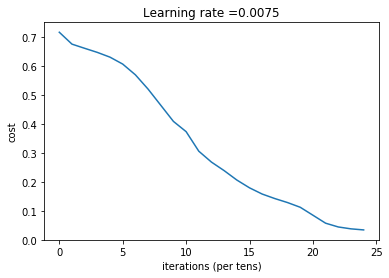

In [13]:
lays_dim = [12288, 20, 7, 5, 1] #  5-layer model
parameters = nn_model(train_x, train_y, lays_dim, learning_rate=0.0075,num_iterations = 2500, print_cost = True,isPlot=True)
# np.random.seed(1)
    
# costs = []
    
# parameters = initialize_parameter_deep(lays_dim)
# L = len(parameters)
# print(L)
# AL,caches = nn_forward_model(train_x,parameters)
# caches_A,caches_Z = caches

# cost = compute_cost(AL,train_y)
# back_parameters = nn_back_model(AL,train_y,parameters,caches)
# parameters = update_parameters(parameters,back_parameters,learning_rate)
# L = len(parameters)
# print(L)

In [16]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确度为: 0.9952153110047847
准确度为: 0.78


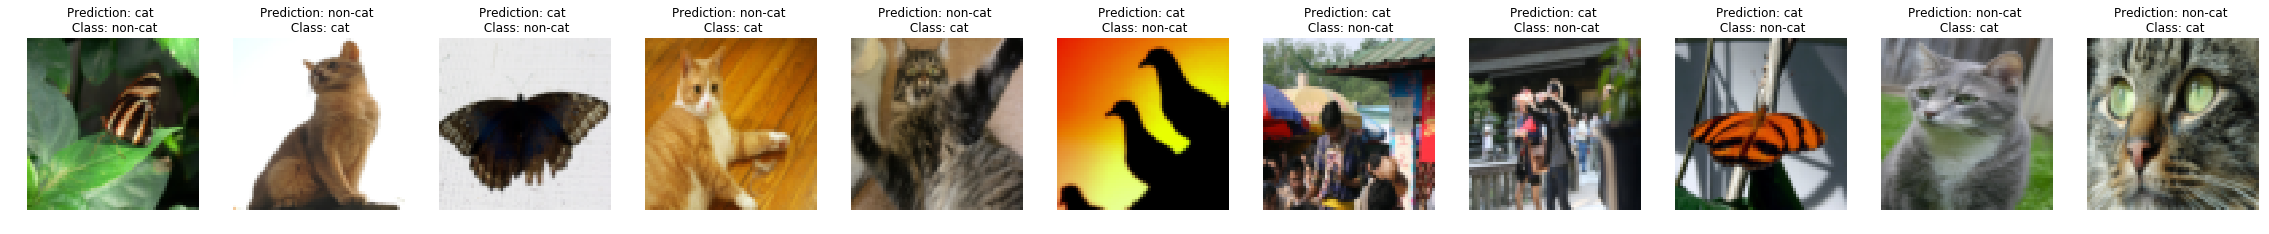

In [17]:
def print_mislabeled_images(classes, X, y, p):
    """
    绘制预测和实际不同的图像。
        X - 数据集
        y - 实际的标签
        p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_images(classes, test_x, test_y, pred_test)

In [18]:
from PIL import Image

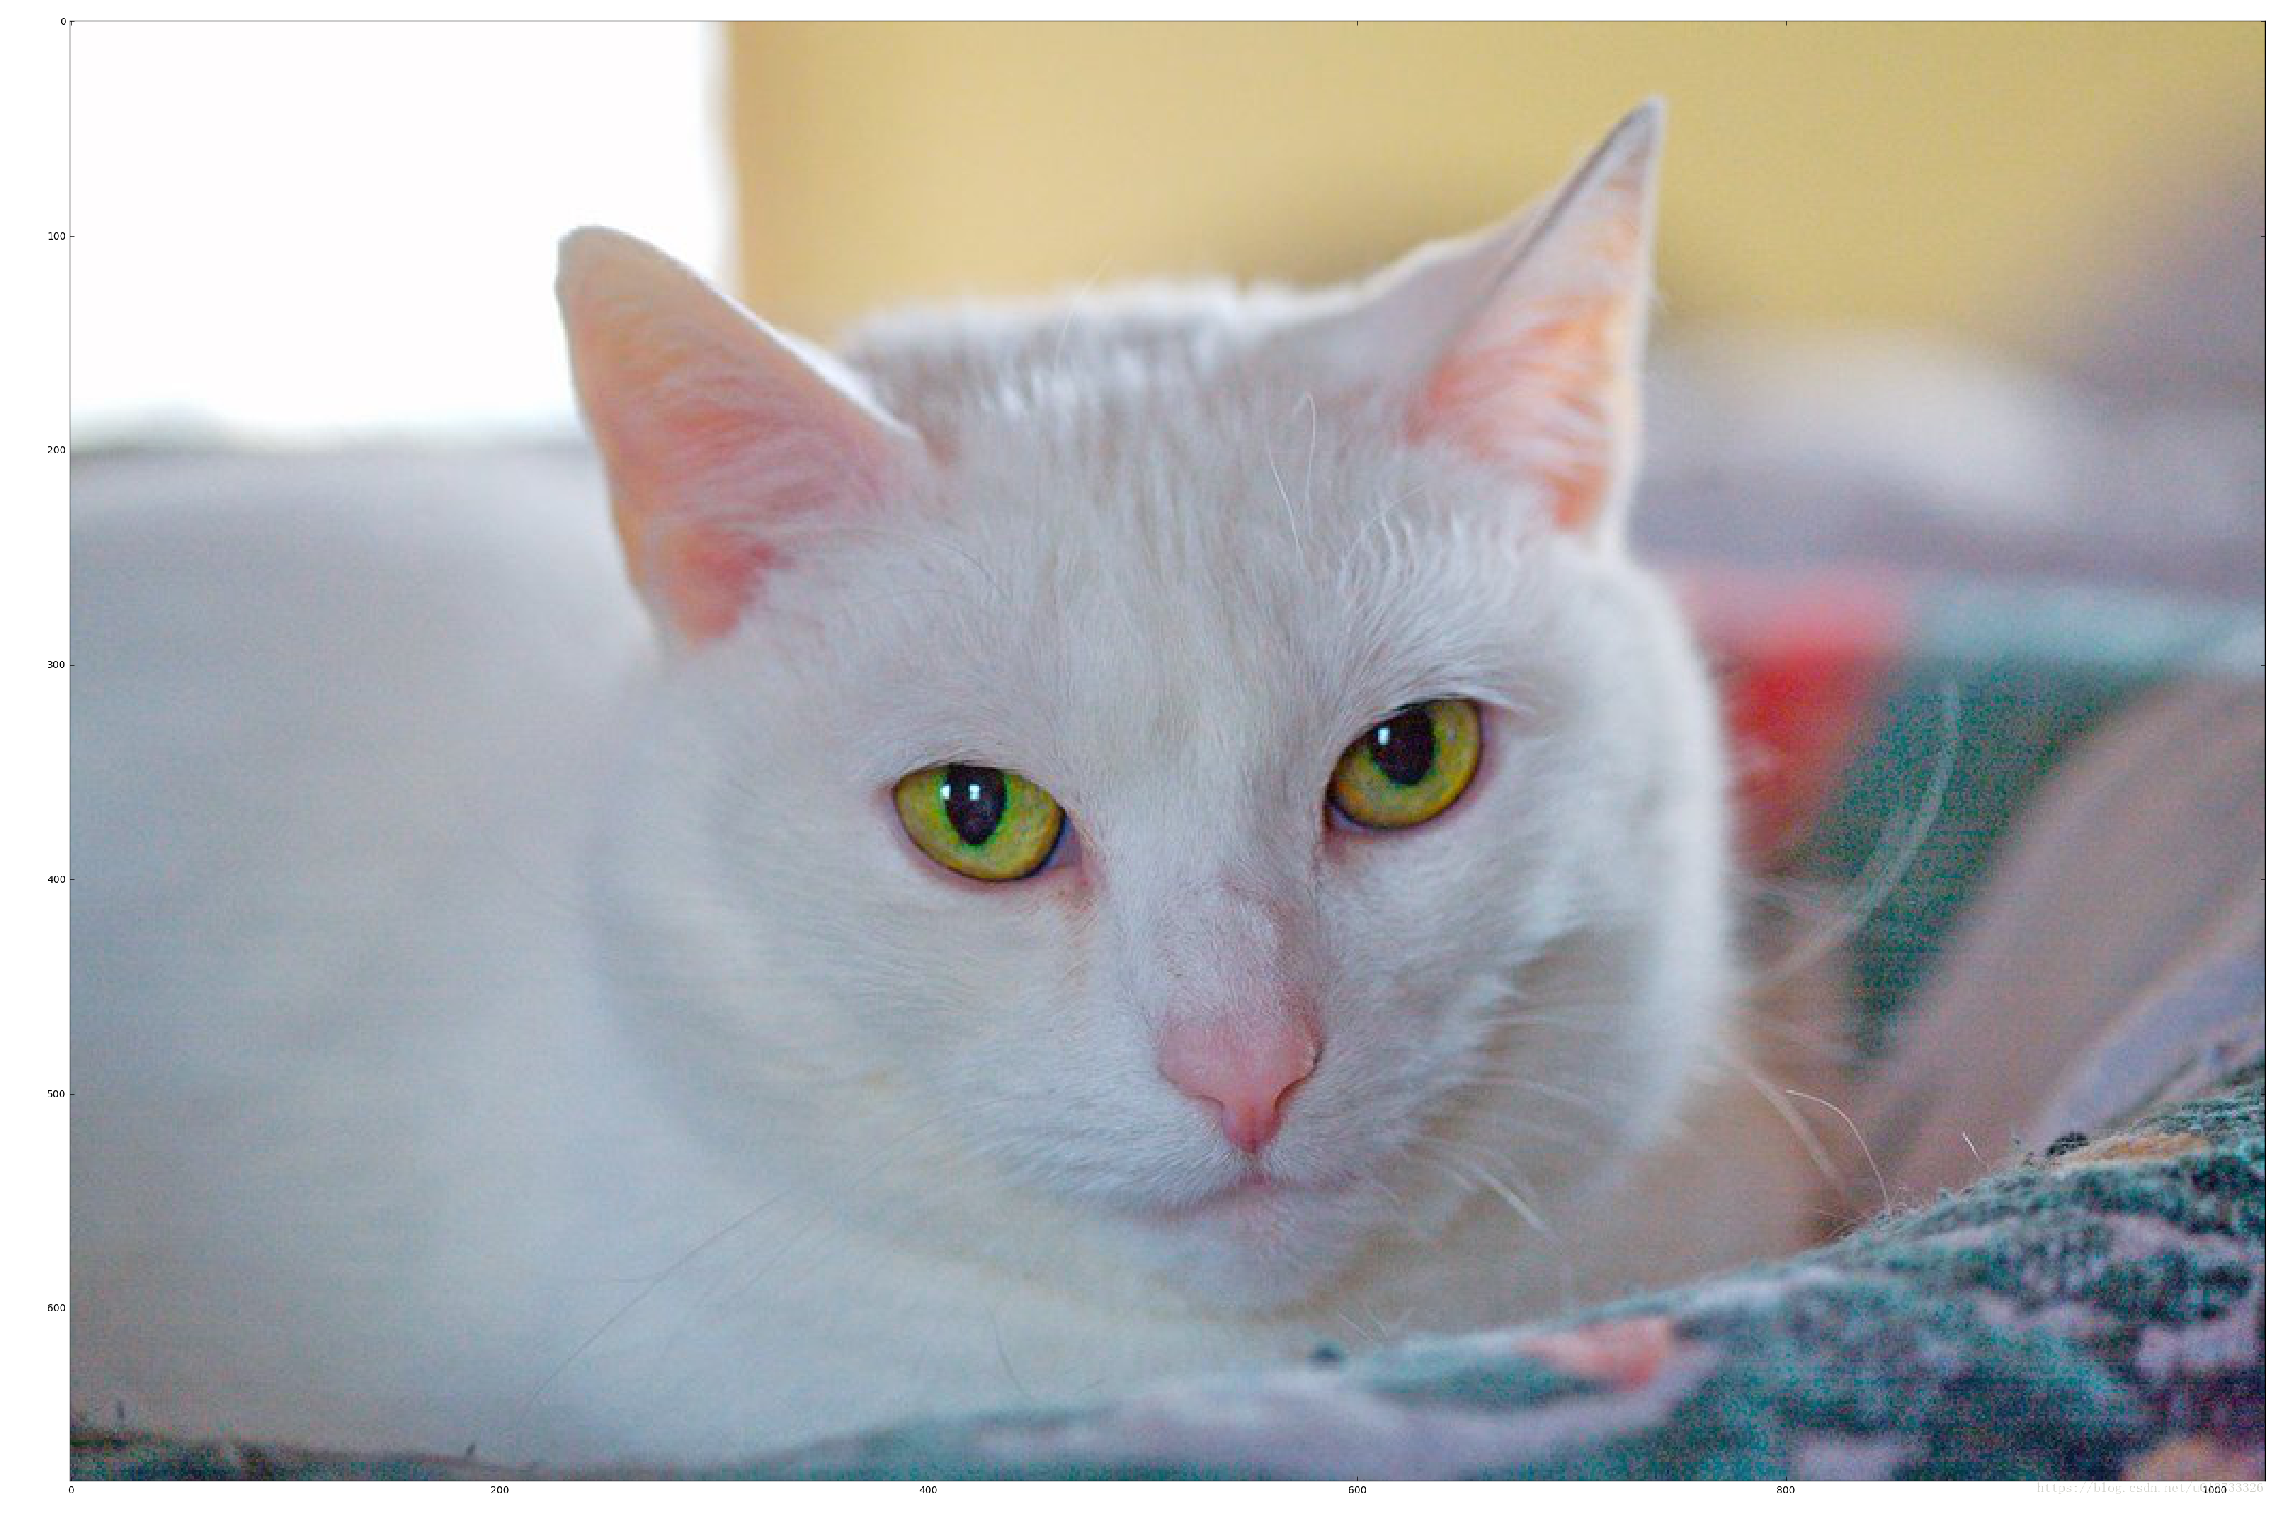

(2106, 3152, 4)

In [25]:
img=np.array(Image.open('C:\\Users\\Shangjian\\Desktop\\20180331173134603.jpg'))  
plt.figure("dog")
plt.imshow(img)
plt.axis('off')
plt.show()


In [33]:
img=np.array(Image.open('C:\\Users\\Shangjian\\Desktop\\20180331173134603.jpg'))
img.shape

(2106, 3152, 4)

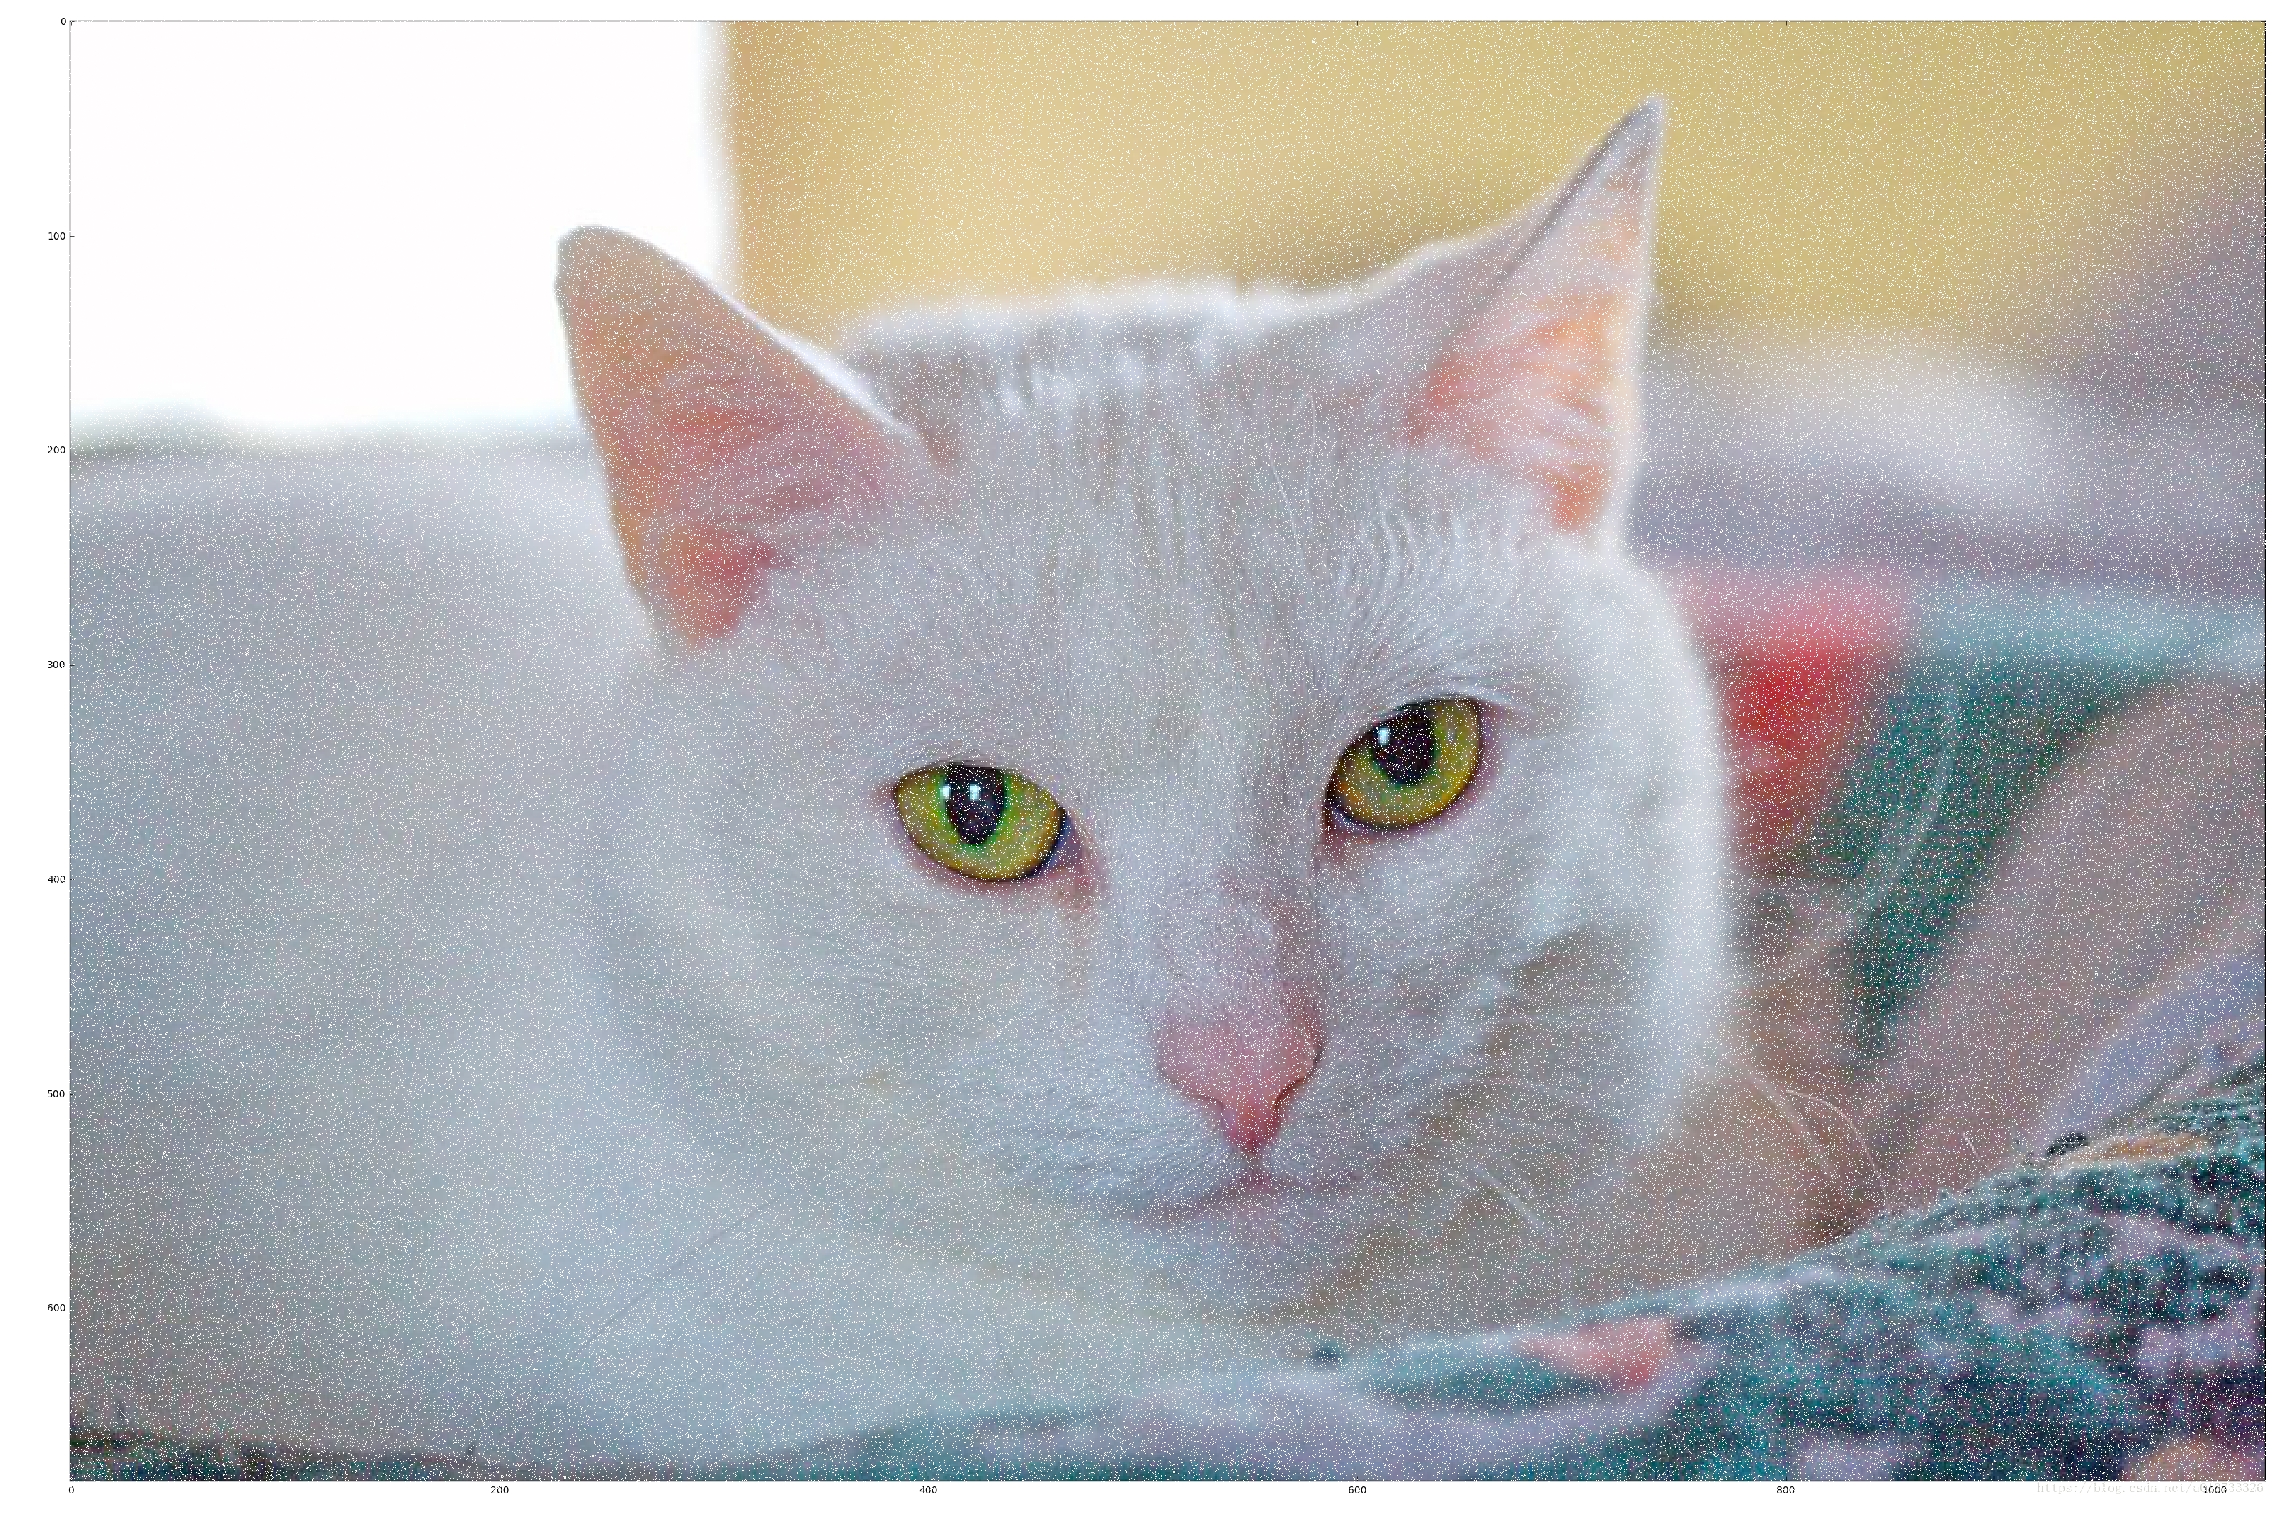

In [34]:
#随机生成5000个椒盐
rows,cols,dims=img.shape
for i in range(500000):
    x=np.random.randint(0,rows)
    y=np.random.randint(0,cols)
    img[x,y,:]=255
    
plt.figure("beauty")
plt.imshow(img)
plt.axis('off')
plt.show()

In [38]:
import scipy.misc
num_px = 64
my_image = scipy.misc.imresize(img, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")


C:\Users\Shangjian\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: cannot reshape array of size 16384 into shape (12288,1)